# 2022-02-03 Newton methods

## Last time

* Discuss rootfinding as a modeling tool
* Limitations of bisection
* Convergence classes
* Intro to Newton methods

## Today

* Newton's method via Taylor series
* Convergence theory for fixed point methods
* Derive Newton's method via convergence theory
* Newton methods in computing culture
* Breaking Newton's method

In [1]:
using Plots
default(linewidth=4, legendfontsize=12)

f(x) = cos(x) - x
hasroot(f, a, b) = f(a) * f(b) < 0
function bisect_iter(f, a, b, tol)
    hist = Float64[]
    while abs(b - a) > tol
        mid = (a + b) / 2
        push!(hist, mid)
        if hasroot(f, a, mid)
            b = mid
        else
            a = mid
        end
    end
    hist
end

bisect_iter (generic function with 1 method)

# Convergence classes

A convergent rootfinding algorithm produces a sequence of approximations $x_k$ such that $$\lim_{k \to \infty} x_k \to x_*$$ where $f(x_*) = 0$.  For analysis, it is convenient to define the errors $e_k = x_k - x_*$. We say that an iterative algorithm is **$q$-linearly convergent** if $$\lim_{k \to \infty} |e_{k+1}| / |e_k| = \rho < 1.$$  (The $q$ is for "quotient".)  A smaller convergence factor $\rho$ represents faster convergence.  A slightly weaker condition ($r$-linear convergence or just **linear convergence**) is that
$$ |e_k| \le \epsilon_k $$
for all sufficiently large $k$ when the sequence $\{\epsilon_k\}$ converges $q$-linearly to 0.

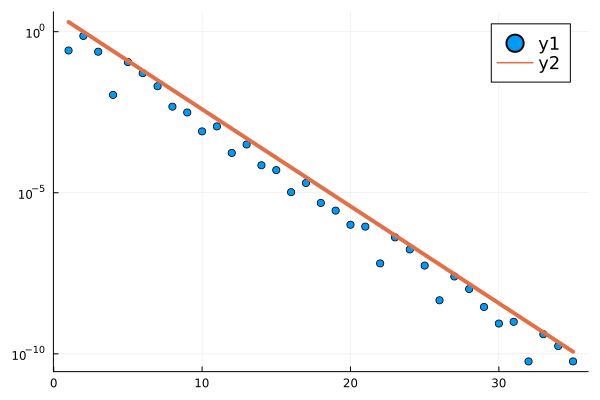

In [2]:
hist = bisect_iter(f, -1, 3, 1e-10)
r = hist[end] # What are we trusting?
hist = hist[1:end-1]
scatter( abs.(hist .- r), yscale=:log10)
ks = 1:length(hist)
ρ = 0.5
plot!(ks, 4 * (ρ .^ ks))

# Newton-Raphson Method

Much of numerical analysis reduces to [Taylor series](https://en.wikipedia.org/wiki/Taylor_series), the approximation
$$ f(x) = f(x_0) + f'(x_0) (x-x_0) + f''(x_0) (x - x_0)^2 / 2 + \underbrace{\dotsb}_{O((x-x_0)^3)} $$
centered on some reference point $x_0$.

In numerical computation, it is exceedingly rare to look beyond the first-order approximation
$$ \tilde f_{x_0}(x) = f(x_0) + f'(x_0)(x - x_0) . $$
Since $\tilde f_{x_0}(x)$ is a linear function, we can explicitly compute the unique solution of $\tilde f_{x_0}(x) = 0$ as
$$ x = x_0 - \frac{f(x_0)}{f'(x_0)} . $$
This is Newton's Method (aka Newton-Raphson or Newton-Raphson-Simpson) for finding the roots of differentiable functions.

# An implementation

In [3]:
function newton(f, fp, x0; tol=1e-8, verbose=false)
    x = x0
    for k in 1:100 # max number of iterations
        fx = f(x)
        fpx = fp(x)
        if verbose
            println("[$k] x=$x  f(x)=$fx  f'(x)=$fpx")
        end
        if abs(fx) < tol
            return x, fx, k
        end
        x = x - fx / fpx
    end  
end

f(x) = cos(x) - x
fp(x) = -sin(x) - 1
newton(f, fp, 1; tol=1e-15, verbose=true)

[1] x=1  f(x)=-0.45969769413186023  f'(x)=-1.8414709848078965
[2] x=0.7503638678402439  f(x)=-0.018923073822117442  f'(x)=-1.6819049529414878
[3] x=0.7391128909113617  f(x)=-4.6455898990771516e-5  f'(x)=-1.6736325442243012
[4] x=0.739085133385284  f(x)=-2.847205804457076e-10  f'(x)=-1.6736120293089505
[5] x=0.7390851332151607  f(x)=0.0  f'(x)=-1.6736120291832148


(0.7390851332151607, 0.0, 5)

# That's really fast!

* 10 digits of accuracy in 4 iterations.
* How is this convergence test different from the one we used for bisection?
* How can this break down?

$$ x_{k+1} = x_k - \frac{f(x_k)}{f'(x_k)} $$

In [15]:
newton(f, fp, -pi/2+.1; verbose=true)

[1] x=-1.4707963267948965  f(x)=1.5706297434417247  f'(x)=-0.0049958347219742905
[2] x=312.9170549232224  f(x)=-312.59435002533314  f'(x)=-0.05350037037604283
[3] x=-5529.927542752894  f(x)=5530.676391917825  f'(x)=-0.33725953180603474
[4] x=10868.945936970244  f(x)=-10868.376227850798  f'(x)=-0.17815359146505727
[5] x=-50136.70732252356  f(x)=50135.70777741902  f'(x)=-1.0301593101044748
[6] x=-1468.7903453577164  f(x)=1468.8859787856973  f'(x)=-1.9954166200403913
[7] x=-732.6603742863299  f(x)=731.8761094362295  f'(x)=-1.6204261800544972
[8] x=-281.0038172368656  f(x)=280.8358913898124  f'(x)=-1.9857996296872256
[9] x=-139.58174866993488  f(x)=139.79912372811944  f'(x)=-0.02391184615360531
[10] x=5706.856156210999  f(x)=-5707.008659764705  f'(x)=-1.9883029222393844
[11] x=2836.5648158265976  f(x)=-2837.5220962814674  f'(x)=-1.2891610809292957
[12] x=635.503879177757  f(x)=-634.8839651181479  f'(x)=-1.784669713127157
[13] x=279.7607629875442  f(x)=-280.7481464325292  f'(x)=-0.841652494

(0.7390851332151608, -2.220446049250313e-16, 24)

# Convergence of fixed-point (by mean value theorem)

Consider the iteration
$$x_{k+1} = g(x_k)$$
where $g$ is a continuously differentiable function.
Suppose that there exists a fixed point $x_* = g(x_*)$.  By the [mean value theorem](https://en.wikipedia.org/wiki/Mean_value_theorem), we have that
$$ x_{k+1} - x_* = g(x_k) - g(x_*) = g'(c_k) (x_k - x_*) $$
for some $c_i$ between $x_k$ and $x_*$.

Taking absolute values, $$|e_{k+1}| = |g'(c_k)| |e_k|,$$ which converges to zero if $|g'(c_k)| < 1$.

![](https://upload.wikimedia.org/wikipedia/commons/e/ee/Mvt2.svg)

# Convergence of fixed-point (by Taylor series)

Consider the iteration
$$x_{k+1} = g(x_k)$$
where $g$ is a continuously differentiable function.
Suppose that there exists a fixed point $x_* = g(x_*)$. There exists a Taylor series at $x_*$,
$$ g(x_k) = g(x_*) + g'(x_*)(x_k - x_*) + O((x_k-x_*)^2) $$
and thus
\begin{align}
x_{k+1} - x_* &= g(x_k) - g(x_*) \\
&= g'(x_*) (x_k - x_*) + O((x_k - x_*)^2).
\end{align}

In terms of the error $e_k = x_k - x_*$,
$$ \left\lvert \frac{e_{k+1}}{e_k} \right\rvert = \lvert g'(x_*) \rvert + O(e_k).$$


## Poll: Is this convergence A=q-linear, B=r-linear, C=neither?


Recall the definition of q-linear convergence
$$ \lim_{k\to\infty} \left\lvert \frac{e_{k+1}}{e_k} \right\rvert = \rho < 1. $$

# Aside: [Big $O$ ("big oh") notation](https://en.wikipedia.org/wiki/Big_O_notation)

## Limit $n\to\infty$

We'd say an algorithm costs $O(n^2)$ if its running time on input of size $n$ is less than $c n^2$ for some constant $c$ and sufficiently large $n$.

Sometimes we write $\operatorname{cost}(\texttt{algorithm}, n) = O(n^2)$ or (preferably) $\operatorname{cost}(\texttt{algorithm}) \in O(n^2)$.

Note that $O(\log n) \subset O(n) \subset O(n\log n) \subset O(n^2) \subset \dotsb$ so it's correct to say "binary search is in $O(n^2)$", even though a sharper statement is also true.

We say the algorithm is in $\Theta(n^2)$ ("big theta") if
$$ c_1 n^2 < \operatorname{cost}(\texttt{algorithm}) < c_2 n^2 $$
for some positive constants $c_1,c_2$ and sufficiently large $n$.

## Limit $h \to 0$

In numerical analysis, we often have a small real number, and now the definitions take the limit as the small number goes to zero. So we say a term in an expression is in $O(h^2)$ if

$$ \lim_{h\to 0} \frac{\operatorname{term}(h)}{h^2} < \infty . $$

Big $O$ terms can be manipulated as

\begin{align}
h O(h^k) &= O(h^{k+1}) \\
O(h^k)/h &= O(h^{k-1}) \\
c O(h^k) &= O(h^k) \\
O(h^k) - O(h^k) &= ?
\end{align}

# Example of a fixed point iteration

We wanted to solve $\cos x - x = 0$, which occurs when $g(x) = \cos x$ is a fixed point.

xstar = 0.739085133385284
gp(xstar) = -0.6736120293089505


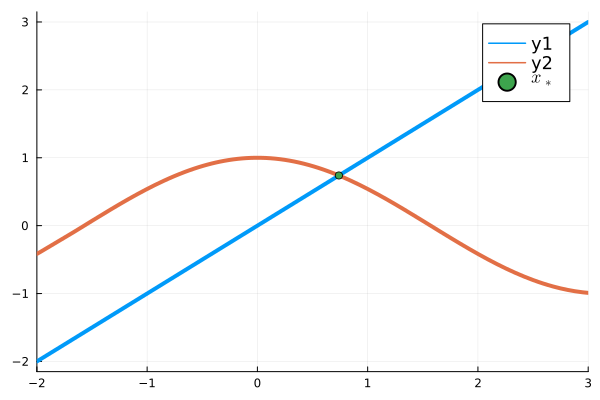

In [5]:
xstar, _ = newton(f, fp, 1.)
g(x) = cos(x)
gp(x) = -sin(x)
@show xstar
@show gp(xstar)
plot([x->x, g], xlims=(-2, 3))
scatter!([xstar], [xstar],
    label="\$x_*\$")

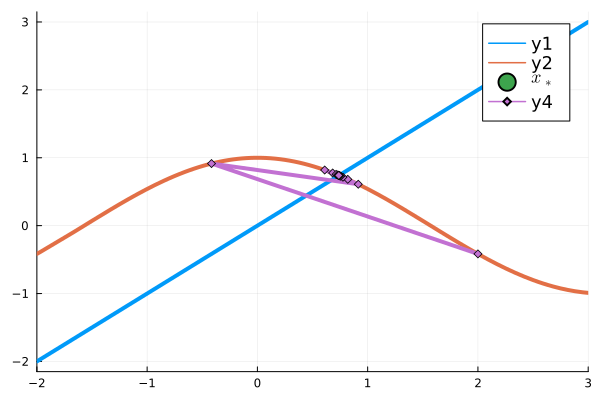

In [6]:
function fixed_point(g, x, n)
    xs = [x]
    for k in 1:n
        x = g(x)
        append!(xs, x)
    end
    xs
end

xs = fixed_point(g, 2., 15)
plot!(xs, g.(xs), seriestype=:path, marker=:auto)

# Verifying fixed point convergence theory


$$ \left\lvert \frac{e_{k+1}}{e_k} \right\rvert \to \lvert g'(x_*) \rvert $$

In [7]:
@show gp(xstar)
es = xs .- xstar
es[2:end] ./ es[1:end-1]

gp(xstar) = -0.6736120293089505


15-element Vector{Float64}:
 -0.9161855415615605
 -0.15197657010596488
 -0.734870205299266
 -0.624132525531327
 -0.7026257933893496
 -0.6523498121376077
 -0.6870971782336925
 -0.664168570025122
 -0.6798044680427148
 -0.6693659427636027
 -0.6764378047956165
 -0.6716930541785153
 -0.6748976495459512
 -0.6727427617641084
 -0.6741962236114177

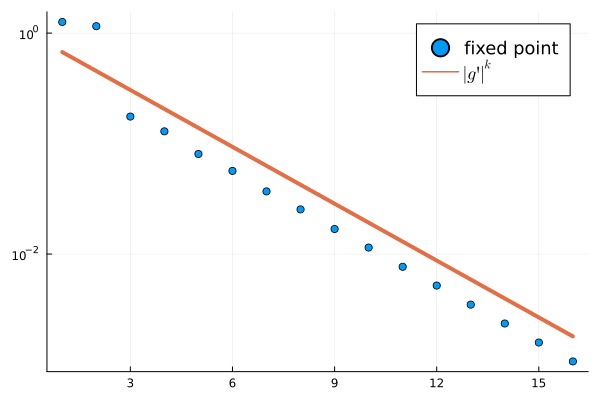

In [8]:
scatter(abs.(es), yscale=:log10, label="fixed point")
plot!(k -> abs(gp(xstar))^k, label="\$|g'|^k\$")

# Plotting Newton convergence

In [9]:
function newton_hist(f, fp, x0; tol=1e-12)
    x = x0
    hist = []
    for k in 1:100 # max number of iterations
        fx = f(x)
        fpx = fp(x)
        push!(hist, [x fx fpx])
        if abs(fx) < tol
            return vcat(hist...)
        end
        x = x - fx / fpx
    end
end

newton_hist (generic function with 1 method)

x_star = xs[end, 1] = 0.7390851332151607


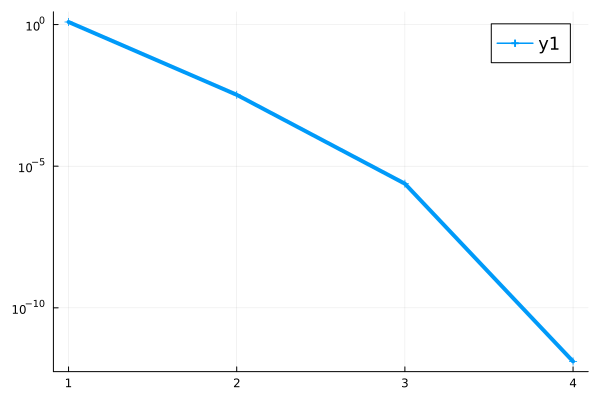

In [10]:
xs = newton_hist(f, fp, 1.97)
@show x_star = xs[end,1]
plot(xs[1:end-1,1] .- x_star, yscale=:log10, marker=:auto)

## Poll: Is this convergence A=q-linear, B=r-linear, C=neither?

# Formulations are not unique (constants)

If $x = g(x)$ then
$$x = \underbrace{x + c(g(x) - x)}_{g_2}$$
for any constant $c \ne 0$. Can we choose $c$ to make $\lvert g_2'(x_*) \rvert$ small?

g2p(xstar) = 0.16319398534552476


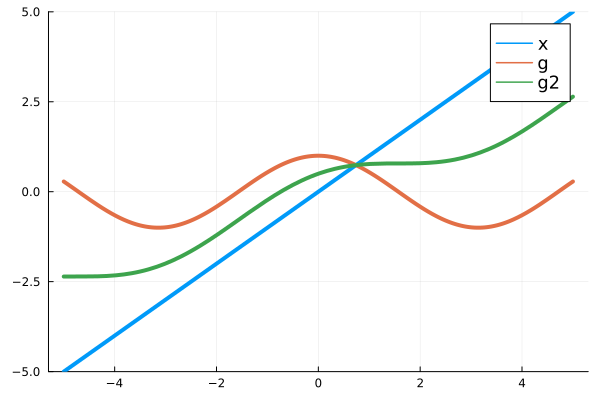

In [11]:
c = .5
g2(x) = x + c * (cos(x) - x)
g2p(x) = 1 + c * (-sin(x) - 1)
@show g2p(xstar)
plot([x->x, g, g2], ylims=(-5, 5), label=["x" "g" "g2"])

In [12]:
xs = fixed_point(g2, 1., 15)
xs .- xstar

16-element Vector{Float64}:
  0.26091486661471597
  0.03106601954878585
  0.004893162344945079
  0.0007941171212053622
  0.00012947850276123773
  2.112687301181193e-5
  3.4475537732392425e-6
  5.62475483634195e-7
  9.16501970982253e-8
  1.4814399151852342e-8
  2.2752605355336186e-9
  2.2894852680366284e-10
 -1.0499723313017739e-10
 -1.594951948291623e-10
 -1.683889694348295e-10
 -1.6984036399492197e-10

# Formulations are not unique (functions)

If $x = g(x)$ then
$$x = \underbrace{x + h(x) \big(g(x) - x\big)}_{g_3(x)}$$
for any smooth $h(x) \ne 0$. Can we choose $h(x)$ to make $\lvert g_3'(x) \rvert$ small?

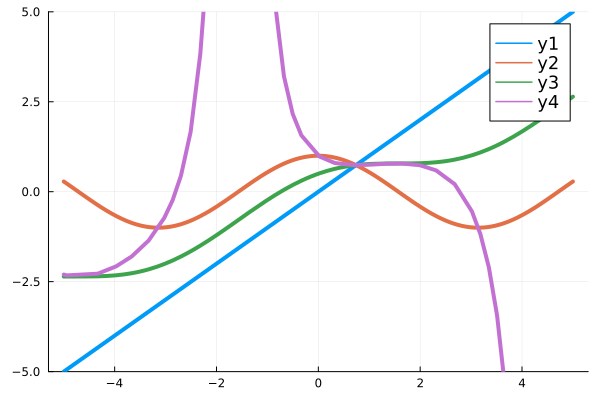

In [13]:
h(x) = -1 / (gp(x) - 1)
g3(x) = x + h(x) * (g(x) - x)
plot([x-> x, cos, g2, g3], ylims=(-5, 5))

* We don't know $g'(x_*)$ in advance because we don't know $x_*$ yet.
* This method converges very fast
* We actually just derived Newton's method.

# A fresh derivation of Newton's method

* A rootfinding problem $f(x) = 0$ can be converted to a fixed point problem $$x = x + f(x) =: g(x)$$ but there is no guarantee that $g'(x_*) = 1 + f'(x_*)$ will have magnitude less than 1.
* Problem-specific algebraic manipulation can be used to make $|g'(x_*)|$ small.
* $x = x + h(x) f(x)$ is also a valid formulation for any $h(x)$ bounded away from $0$.
* Can we choose $h(x)$ such that $$ g'(x) = 1 + h'(x) f(x) + h(x) f'(x) = 0$$ when $f(x) = 0$?

In other words,
$$ x_{k+1} = x_k + \underbrace{\frac{-1}{f'(x_k)}}_{h(x_k)} f(x_k)  . $$

# Quadratic convergence!

$$ \left\lvert \frac{e_{k+1}}{e_k} \right\rvert \to \lvert g'(x_*) \rvert $$

* What does it mean that $g'(x_*) = 0$?
* It turns out that Newton's method has _locally quadratic_ convergence to simple roots,
$$\lim_{k \to \infty} \frac{|e_{k+1}|}{|e_k|^2} < \infty.$$
* "The number of correct digits doubles each iteration."
* Now that we know how to make a good guess accurate, the effort lies in getting a good guess.

# Culture: fast inverse square root

The following code appeared literally (including comments) in the Quake III Arena source code (late 1990s).

```C
float Q_rsqrt( float number )
{
	long i;
	float x2, y;
	const float threehalfs = 1.5F;

	x2 = number * 0.5F;
	y  = number;
	i  = * ( long * ) &y;                       // evil floating point bit level hacking
	i  = 0x5f3759df - ( i >> 1 );               // what the fuck? 
	y  = * ( float * ) &i;
    y  = y * ( threehalfs - ( x2 * y * y ) );   // 1st iteration
//  y  = y * ( threehalfs - ( x2 * y * y ) );   // 2nd iteration, this can be removed

	return y;
}
```

We now have [vector instructions](https://software.intel.com/sites/landingpage/IntrinsicsGuide/#text=rsqrt&expand=2989,1224,4470) for approximate inverse square root.
More at https://en.wikipedia.org/wiki/Fast_inverse_square_root

# How does it work?

Let's look at the last line
```c
y  = y * ( threehalfs - ( x2 * y * y ) );   // 1st iteration
```

We want a function $f(y)$ such that $f(1/\sqrt{x}) = 0$. One such function is
$$ f(y) = 1/y^2 - x, \quad f'(y) = -2/y^3.$$

There are others, e.g.,
$$f_1(y) = y^2 - 1/x,\quad f'(y) = 2 y,$$
but this would require a division.

Newton's method is
\begin{align}
y_{k+1} &= y_k - \frac{f(y_k)}{f'(y_k)} \\
&= y_k - \frac{1/y_k^2 - x}{-2/y_k^3} \\
&= y_k + \frac 1 2 (y_k - x y_k^3) \\
&= y_k \left(\frac 3 2 - \frac 1 2 x y_k^2\right)
\end{align}

# Rootfinding outlook

* Newton methods are immensely successful
  * Convergence theory is local; we need good initial guesses (activity)
  * Computing the derivative $f'(x)$ is *intrusive*
    * Avoided by secant methods (approximate the derivative; activity)
    * Algorithmic or numerical differentiation (future topics)
  * Bisection is robust when conditions are met
  * Line search (activity)
  * When does Newton diverge?

* More topics
  * Find *all* the roots
  * Use Newton-type methods with bounds
  * Times when Newton converges slowly